In [1]:
!pip install Keras-Preprocessing
!pip install datasets
!pip install rouge_score
!pip install nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and pl

In [2]:
import math
import os
import gc
import time
import re
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from google.colab import drive

In [3]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
import os
import gc
import time
import re
import unicodedata
import nltk

In [5]:
# Parameters for our model
NUM_SAMPLES = 25000 #40000
max_vocab_size = 5000

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 2  # Number of epochs to train for.
MAX_SUMM_LENGTH = 12
MAX_TEXT_LENGTH = 60
embedding_dim = 300
UNITS = 1024
DROPOUT_RATE= 0.2
LEARNING_RATE = 0.001
# Seed
SEED=42
train_frac=0.85
#Experiment parameters
save_checkpoints = False


In [7]:
from google.colab import files
uploaded=files.upload()

Saving 5k_sar_nonsar.csv to 5k_sar_nonsar.csv


In [8]:
data = pd.read_csv("5k_sar_nonsar.csv")

In [ ]:
data


,Sarcastic,non_sarcastic,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,best day of my life,worst day of my life,\n,\n,\n
1,best day of my life,worst day of my life,\n,\n,\n
2,best day of my life,i had a horrible day,\n,\n,\n
3,best day of my life,worst day of my life,\n,\n,\n
4,best day of my life,i have never had a day worse than this in my ...,\n,\n,\n
...,...,...,...,...,...
4995,obviously i love having to do all of this all ...,obviously i hate having to do all of this all ...,\n,\n,\n
4996,obviously i love having to do all of this all ...,i hate doing the editing work over and over a...,\n,\n,\n
4997,obviously i love having to do all of this all ...,obviously i hate having to do all of this all ...,\n,\n,\n
4998,obviously i love having to do all of this all ...,i hate having to do all of this all over again...,\n,\n,\n


In [ ]:
data.shape

(5000, 5)

In [9]:
# Load the train dataset: text and summary
train_df=pd.read_csv('/content/5k_sar_nonsar.csv', header=0, usecols=[0,1],
               nrows=NUM_SAMPLES)

print('Number of train sentences: ',len(train_df))

Number of train sentences:  5000


In [10]:
input_train = '<start> '+train_df['Sarcastic'].values+' <end>'
output_train = '<start> '+train_df['non_sarcastic'].values+' <end>'

print(input_train[10])
print(output_train[10])

<start>  love how a lot of ppl quit clash for agar io <end>
<start>  hate how a lot of ppl quit clash for agar io <end>


In [12]:
input_train_list=list(input_train)

In [13]:
output_train_list=list(output_train)

In [14]:
def word_tokenize(input_data, max_vocab_size, max_length=None, OOV_token=None,
                  filters='', padding=True):
    # Create a tokenizer for the input texts and fit it to them
    tokenizer = Tokenizer(num_words=max_vocab_size, filters=filters, oov_token=OOV_token)
    tokenizer.fit_on_texts(input_data)
    # Tokenize and transform input texts to sequence of integers
    output_sequences = tokenizer.texts_to_sequences(input_data)
    # Calculate the max length
    output_max_len = max(len(s) for s in output_sequences)
    # Apply padding and truncate if required
    if padding:
        if max_length is not None:
            # Updated line to use pad_sequences from tensorflow.keras.utils
            output_sequences = tf.keras.utils.pad_sequences(output_sequences, maxlen=max_length,
                                            truncating='post', padding='post')
        else:
            output_sequences = tf.keras.utils.pad_sequences(output_sequences, padding='post')

    return output_sequences, tokenizer, output_max_len

In [15]:
def word_tokenize(output_data, max_vocab_size, max_length=None, OOV_token=None,
                  filters='', padding=True):
    # Create a tokenizer for the input texts and fit it to them
    tokenizer = Tokenizer(num_words=max_vocab_size, filters=filters, oov_token=OOV_token)
    tokenizer.fit_on_texts(output_data)
    # Tokenize and transform input texts to sequence of integers
    output_sequences = tokenizer.texts_to_sequences(output_data)
    # Calculate the max length
    output_max_len = max(len(s) for s in output_sequences)
    # Apply padding and truncate if required
    if padding:
        if max_length is not None:
            # Updated line to use pad_sequences from tensorflow.keras.utils
            output_sequences = tf.keras.utils.pad_sequences(output_sequences, maxlen=max_length,
                                            truncating='post', padding='post')
        else:
            output_sequences = tf.keras.utils.pad_sequences(output_sequences, padding='post')

    return output_sequences, tokenizer, output_max_len

In [16]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, input_max_length = word_tokenize(input_train,max_vocab_size,MAX_TEXT_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, output_max_length = word_tokenize(output_train,max_vocab_size, MAX_SUMM_LENGTH)

In [ ]:
input_train

array(['<start> \xa0best day of my life <end>',
       '<start> \xa0best day of my life <end>',
       '<start> \xa0best day of my life <end>', ...,
       '<start> obviously i love having to do all of this all over again and edit out 10000 ahms another time <end>',
       '<start> obviously i love having to do all of this all over again and edit out 10000 ahms another time <end>',
       '<start> obviously i love having to do all of this all over again and edit out 10000 ahms another time <end>'],
      dtype=object)

In [ ]:
# Check the tokenize function
print(encoder_inputs[:3])
print(decoder_outputs[:3])
print(input_max_length, output_max_length)

[[  1 411  41   8  12  73   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1 411  41   8  12  73   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1 411  41   8  12  73   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]
[[  1 552  39   9  13  79   2   0   0   0   0   0]
 [  1 552  39   9  13  79   2   0   0   0   0   0]
 [  1  11 131   5 107  39   2   0   0   0   0   0]]
33 44


In [ ]:
encoder_inputs

array([[   1,  422,   42, ...,    0,    0,    0],
       [   1,  422,   42, ...,    0,    0,    0],
       [   1,  422,   42, ...,    0,    0,    0],
       ...,
       [   1, 1202,    6, ...,    0,    0,    0],
       [   1, 1202,    6, ...,    0,    0,    0],
       [   1, 1202,    6, ...,    0,    0,    0]], dtype=int32)

In [ ]:
type(decoder_outputs)

numpy.ndarray

In [ ]:
type(input_max_length)

int

In [17]:

def tensor_to_text(tokenizer, tensors):
  texts=[]
  for tensor in tensors:
      text=[tokenizer.index_word.get(t, '<unk>') for t in tensor if t!=0]
      texts.append(' '.join(text))

  return texts

In [113]:
t= tf.ones((64,60), dtype=tf.int64)
tensor_to_text(tokenizer_inputs, t.numpy())

In [114]:

t= tf.ones((64,60), dtype=tf.int64)
tensor_to_text(tokenizer_outputs, t.numpy())


In [20]:
train_enc_inputs, val_enc_inputs, train_dec_outputs, val_dec_outputs, = train_test_split(encoder_inputs, decoder_outputs,
                                                                                       train_size=train_frac,random_state=SEED, shuffle=True )
print(train_enc_inputs.shape)
print(train_dec_outputs.shape)
print(val_enc_inputs.shape)
print(val_dec_outputs.shape)

(4250, 60)
(4250, 12)
(750, 60)
(750, 12)


In [21]:
BUFFER_SIZE = len(train_enc_inputs)
steps_per_epoch = len(train_enc_inputs)//BATCH_SIZE
val_steps_per_epoch = len(val_enc_inputs)//BATCH_SIZE


In [22]:
# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_inputs=len(tokenizer_inputs.word_index)+1
num_words_outputs=len(tokenizer_outputs.word_index)+1

In [23]:
num_words_in=tokenizer_inputs.word_index.items()
num_words_out=tokenizer_outputs.word_index.items()

In [24]:
input_vocab_size = tokenizer_inputs.num_words
output_vocab_size = tokenizer_outputs.num_words

In [ ]:
print('Size of Input Vocabulary: ', num_words_in)
print('Size of Output Vocabulary: ', num_words_out)

Size of Input Vocabulary:  dict_items([('<start>', 1), ('<end>', 2), ('the', 3), ('to', 4), ('a', 5), ('i', 6), ('is', 7), ('and', 8), ('of', 9), ('in', 10), ('?', 11), ('my', 12), ('you', 13), ('for', 14), ('be', 15), ('that', 16), ('it', 17), ('on', 18), ('so', 19), ('\xa0i', 20), ('me', 21), ('are', 22), ('have', 23), ('just', 24), ('love', 25), ('this', 26), ('like', 27), ('at', 28), ('with', 29), ('great', 30), ("i'm", 31), ('all', 32), ('up', 33), ('people', 34), ('what', 35), ('when', 36), ('not', 37), ('out', 38), ('get', 39), ('was', 40), ('but', 41), ('day', 42), ('really', 43), ('how', 44), ('your', 45), ("don't", 46), ('more', 47), ('fun', 48), ("it's", 49), ('we', 50), ('know', 51), ('they', 52), ('do', 53), ('going', 54), ('now', 55), ('one', 56), ('about', 57), ('today', 58), ('from', 59), ('much', 60), ('good', 61), ('time', 62), ('being', 63), ('work', 64), ('go', 65), ('who', 66), ('been', 67), ('as', 68), ('or', 69), ('can', 70), ('because', 71), ('if', 72), ('am', 7

In [ ]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_outputs)

Size of Input Vocabulary:  3640
Size of Output Vocabulary:  5008


In [ ]:
print('Size of Input Vocabulary: ', input_vocab_size)
print('Size of Output Vocabulary: ', output_vocab_size)

Size of Input Vocabulary:  5000
Size of Output Vocabulary:  5000


In [25]:
# Define a train dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (train_enc_inputs, train_dec_outputs))
dataset = dataset.shuffle(train_enc_inputs.shape[0], reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define a validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_enc_inputs, val_dec_outputs))
val_dataset = val_dataset.batch(
    BATCH_SIZE, drop_remainder=True)

val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
print(example_input_batch)

tf.Tensor(
[[   1   19  179 ...    0    0    0]
 [   1   20   24 ...    0    0    0]
 [   1 3183  839 ...    0    0    0]
 ...
 [   1 2047 1020 ...    0    0    0]
 [   1 3352    6 ...    0    0    0]
 [   1  626  291 ...    0    0    0]], shape=(64, 60), dtype=int32)


In [27]:
#map indexes back into real words

idx2word_inputs = {v:k for k, v in tokenizer_inputs.word_index.items()}
idx2word_outputs = {v:k for k, v in tokenizer_outputs.word_index.items()}

# Spacy embedding

In [28]:
import spacy


In [29]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [30]:
# CREATING AN EMBEDDING MATRIX
emd_dim=300
def create_embedding_matrix(input_vocab_size, embedding_dim, vocab, idx2word_inputs):
    # Initialize the embedding matrix with random values
    embedding_matrix = np.random.randn(input_vocab_size, embedding_dim)
    for i in range(1,input_vocab_size-1):
        # Check if the key 'i' exists in idx2word_inputs before accessing it
        if i in idx2word_inputs:
            token = idx2word_inputs[i]
            if vocab[token].has_vector:
                embedding_matrix[i] = vocab[token].vector
        else:
         print(f"Key {i} not found in idx2word_inputs")

    return embedding_matrix

In [31]:
# Create the out_embedding matrix
embedding_matrix_out = create_embedding_matrix(output_vocab_size, embedding_dim, nlp.vocab, idx2word_outputs)

In [32]:
# Create the input_embedding matrix
embedding_matrix_in = create_embedding_matrix(input_vocab_size, embedding_dim, nlp.vocab, idx2word_outputs)

# Glove embedding

In [ ]:
import os
import urllib.request
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7bff71b87cd0>)

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"

Archive:  /content/glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
#Import pretrained Glove embedding
embeddings_index = {}
f = open('/content/glove.6B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
hits = 0
misses = 0
# Prepare embedding matrix for input
embedding_matrix_in = np.zeros((input_vocab_size, embedding_dim))
for word, i in num_words_in:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_in[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3043 words (572 misses)


In [ ]:
hits = 0
misses = 0
# Prepare embedding matrix for input
embedding_matrix_out = np.zeros((output_vocab_size, embedding_dim))
for word, i in num_words_out:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        if i < output_vocab_size:
          embedding_matrix_out[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3933 words (1001 misses)


# word2vec

In [ ]:
import gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model1 = Word2Vec(input_train_list,vector_size=100, window=5, min_count=1, sg=0)

In [ ]:
w2v_model2 = Word2Vec(output_train_list,vector_size=100, window=5, min_count=1, sg=0)

In [ ]:
w2v_model1.save("word2vec_model.model")

In [ ]:
w2v_model2.save("word2vec_model.model")

In [ ]:
# Load the trained Word2Vec model (or replace with your own model file)
w2v_model1 = Word2Vec.load("word2vec_model.model")

In [ ]:
# Load the trained Word2Vec model (or replace with your own model file)
w2v_model2 = Word2Vec.load("word2vec_model.model")

In [ ]:
def create_embedding_matrix_in(num_words_in,vector_size, w2v_model1,embedding_dim):
    embedding_dim = w2v_model1.vector_size
    #vocab_size = num_words_inputs # Add 1 for the zero-padding token
    embedding_matrix = np.zeros((input_vocab_size, embedding_dim))

    for word, i in num_words_in:
        if word in w2v_model1.wv:
            embedding_matrix[i] = w2v_model1.wv[word]

    return embedding_matrix

In [ ]:
def create_embedding_matrix_ou(num_words_out,vector_size, w2v_model2,embedding_dim):
    embedding_dim = w2v_model2.vector_size
    #vocab_size = num_words_outputs # Add 1 for the zero-padding token
    embedding_matrix = np.zeros((output_vocab_size, embedding_dim))

    for word, i in num_words_out:
        if word in w2v_model1.wv:
            embedding_matrix[i] = w2v_model1.wv[word]

    return embedding_matrix

In [ ]:
vector_size=100

In [ ]:
print(num_words_inputs)

3640


In [ ]:
input_vocab_size

5000

In [115]:
# Create the input_embedding matrix
embedding_matrix_in = create_embedding_matrix_in(num_words_in, vector_size, w2v_model1,embedding_dim)

In [ ]:
embedding_matrix_in.shape

(5000, 100)

In [ ]:
embedding_matrix_in

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Create the output_embedding matrix
embedding_matrix_out = create_embedding_matrix_ou(num_words_out, vector_size, w2v_model2,embedding_dim)

In [ ]:
embedding_matrix_out.shape

(5000, 100)

In [143]:
# Create the Encoder based on Bidirectional LSTMs
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout_rate, embedding_matrix):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.dropout_rate = dropout_rate
        #self.outputs = {}
        self.states = {}
        if embedding_matrix is not None:
            #self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, weights = [embedding_matrix])
            self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim,
                                                       embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix))
        else:
            self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim)



        self.lstmb1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state= True,
                                                                         dropout=self.dropout_rate, go_backwards=False), merge_mode='sum')

        self.lstmb3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=self.dropout_rate, go_backwards=False), merge_mode='sum')

    def call(self, x, training=True):
        x = self.embedding(x)

        x, hidden_forward, cell_forward, hidden_backward, cell_backward = self.lstmb1(x,
                                                                                      training=training)

        outputs, self.states["for_h"], self.states["for_c"], self.states["bac_h"], self.states["bac_c"] = self.lstmb3(x, initial_state=[hidden_forward,
                                                                                                        cell_forward, hidden_backward, cell_backward],
                                                                                                        training=training)
        return outputs, self.states


    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)),tf.zeros((self.enc_units, self.enc_units))]

In [144]:
encoder = Encoder(input_vocab_size, embedding_dim, UNITS, BATCH_SIZE, 0.5, embedding_matrix_in)

print('Input shape: ', example_input_batch.shape)
outputs, states = encoder(example_input_batch)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(outputs.shape))
print ('Encoder Forward states shape: (batch size, units) {} - {}'.format(states["for_h"].shape, states["for_c"].shape))
print ('Encoder For-Back Cell state shape: (batch size, units) {} - {}'.format(states["bac_h"].shape, states["bac_c"].shape))

Input shape:  (64, 60)
Encoder output shape: (batch size, sequence length, units) (64, 60, 1024)
Encoder Forward states shape: (batch size, units) (64, 1024) - (64, 1024)
Encoder For-Back Cell state shape: (batch size, units) (64, 1024) - (64, 1024)


In [ ]:
#global attention
class GlobalAttention(Layer):
    def __init__(self):
        super(GlobalAttention).__init__()
        self.W = Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.W(query_with_time_axis)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [145]:
#Bahdanau Attention
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):

    query_with_time_axis = tf.expand_dims(query, 1)


    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))


    attention_weights = tf.nn.softmax(score, axis=1)


    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
#local attention
from tensorflow.keras.layers import Layer,Concatenate, Dense
window_size = 5
class LocalAttention(tf.keras.layers.Layer):
    def __init__(self, window_size):
        super(LocalAttention, self).__init__()
        self.window_size = window_size

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = tf.matmul(query_with_time_axis, values, transpose_b=True)
        score = tf.squeeze(score, axis=1)
        attention_weights = tf.nn.softmax(score[:, -self.window_size:], axis=-1)  # Consider only the local window
        context_vector = tf.matmul(tf.expand_dims(attention_weights, axis=1), values)
        context_vector = tf.squeeze(context_vector, axis=1)
        return context_vector, attention_weights

In [146]:
# DEFINING THE DECODER CLASS OF MODEL

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout_rate, embedding_matrix):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.dropout_rate = dropout_rate
    if embedding_matrix is not None:
        #self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, weights = [embedding_matrix])
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim,
                                                   embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix))
    else:
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim)

    self.lstm1 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)


    self.lstm3 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)

    self.fc = tf.keras.layers.Dense(vocab_size)
    #self.attention = LocalAttention(self.dec_units)
    self.attention = BahdanauAttention(self.dec_units)
    #self.attention = LuongAttention(self.dec_units)


  def call(self, inputs, Training=True):

    x, enc_output, hidden = inputs

    x = self.embedding(x)

    x, h, c = self.lstm1(x, initial_state = hidden)

    context_vector, attention_weights = self.attention(h, enc_output)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    x, h, c = self.lstm3(x, initial_state= [h, c])
    states = [h, c]

    x = tf.reshape(x, (-1, x.shape[2]))

    x = self.fc(x)

    return x, states, attention_weights

In [147]:
decoder = Decoder(output_vocab_size, embedding_dim, UNITS, BATCH_SIZE, 0.5, embedding_matrix_out)

sample_hidden = [tf.add(states["for_h"], states["bac_h"]), tf.add(states["for_c"], states["bac_c"])]
sample_output = outputs
inputs = (tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_output, sample_hidden)
sample_decoder_output, dec_states, attention_weights = decoder(inputs)

hidden, cell = dec_states
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print ('Decoder hidden shape: (batch_size, LSTM units) {}'.format(hidden.shape))
print ('Decoder cell shape: (batch_size, LSTM units) {}'.format(cell.shape))
print ('Attention shape: (batch_size, LSTM units) {}'.format(attention_weights.shape))

Decoder output shape: (batch_size, vocab size) (64, 5000)
Decoder hidden shape: (batch_size, LSTM units) (64, 1024)
Decoder cell shape: (batch_size, LSTM units) (64, 1024)
Attention shape: (batch_size, LSTM units) (64, 60, 1)


In [38]:
import tensorflow_datasets as tfds
import datasets

In [39]:
# Install evaluate package
!pip install evaluate

# Import evaluate instead of load_metric
import evaluate

# Load the ROUGE metric  # Changed to 'rouge'
metric_rouge = evaluate.load("rouge")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [40]:
!pip install rouge_score

In [41]:
from rouge_score import rouge_scorer

In [148]:
def parse_score(result):
    # Check if 'bleu' is in the keys, indicating BLEU score
    if 'bleu' in result:
     return {'bleu': round(result['bleu'] * 100, 4)}  # BLEU score

    else:
     return {k: round(v * 100, 4) for k, v in result.items()}  # ROUGE score


In [149]:
#rouge score
def calculate_rouge(references, predictions):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    # Aggregate scores across all examples
    all_scores = {k: 0.0 for k in ['rouge1', 'rouge2', 'rougeL']}  # Initialize scores to 0
    for ref, pred in zip(references, predictions):
        scores = scorer.score(ref[0], pred)
        for k, v in scores.items():
            all_scores[k] += v.fmeasure  # Accumulate F-measure scores
    # Calculate average scores
    num_examples = len(references)
    avg_scores = {k: round(v / num_examples * 100, 4) for k, v in all_scores.items()}  # Calculate averages
    return avg_scores

In [45]:
# Install evaluate package
!pip install evaluate

# Import evaluate instead of load_metric
import evaluate

# Load the BLEU metric
metric = evaluate.load("bleu")


In [150]:
#loss calculation of model
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [151]:
@tf.function
def train_step(inputs):
  inp, targ = inputs
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_states = encoder(inp)

    #dec_hidden = enc_hidden
    dec_hidden = [ tf.add(enc_states["for_h"], enc_states["bac_h"]), tf.add(enc_states["for_c"],
                                enc_states["bac_c"]) ]

    dec_input = tf.expand_dims([tokenizer_outputs.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      #call(self, x, enc_output, hidden)

      #predictions, dec_hidden = decoder((dec_input, enc_output, dec_hidden))
      predictions, dec_hidden, _ = decoder((dec_input, enc_output, dec_hidden))
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [152]:
@tf.function
def eval_step(inputs):

    inp, targ = inputs
    loss = 0

    enc_output, enc_states = encoder(inp, training=False)
    dec_hidden = [ tf.add(enc_states["for_h"], enc_states["bac_h"]), tf.add(enc_states["for_c"],
                          enc_states["bac_c"]) ]
    dec_input = tf.expand_dims([tokenizer_outputs.word_index['<start>']] * BATCH_SIZE, 1)
    result_ids = tf.one_hot([tokenizer_outputs.word_index['<start>']]*BATCH_SIZE,
                            output_vocab_size, dtype=tf.float32)
    result_ids = tf.expand_dims(result_ids,axis=1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder

      predictions, dec_hidden,_ = decoder((dec_input, enc_output, dec_hidden), training=False)
      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

      result_ids = tf.concat([result_ids , tf.expand_dims(predictions, axis=1)], 1)

    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss, result_ids

In [153]:
def main_train(dataset, val_dataset, n_epochs, steps_per_epoch, val_steps_per_epoch,
               save_checkpoints=False, logging= False, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  train_losses = []
  val_losses = []
  val_metric = []
  val=[]
  main_train.val_bleu=0
  main_train.val_metric=0
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    train_loss.reset_state()

    total_loss = 0

    for (batch, dataset_inputs) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(dataset_inputs)
        train_loss.update_state(batch_loss)

        total_loss += batch_loss

        if batch % print_every == 0:
            print('Train: Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,batch_loss.numpy()))
    epoch_loss = total_loss / steps_per_epoch
    train_losses.append(epoch_loss)
    # Register in wandb
    if logging:
        wandb.log({"Training Loss": epoch_loss})

    # Reset the validation losss and accuracy calculations
    val_loss.reset_state()
    total_loss = 0

    # Evaluation loop

    for (batch, dataset_inputs) in enumerate(val_dataset.take(val_steps_per_epoch)):
        _, targ = dataset_inputs
        batch_loss, preds = eval_step(dataset_inputs)#, enc_hidden)
        val_loss.update_state(batch_loss)

        total_loss += batch_loss
        # Add the predictions to the metric
        #Convert sequence to text

        preds = tf.argmax(preds, axis=-1)
        predictions = tensor_to_text(tokenizer_outputs, preds.numpy())

        references = tensor_to_text(tokenizer_outputs, targ.numpy())

        references = [re.sub(r'(<start>|<end>)', '', ref).strip() for ref in references]
        #Reshape the references
        references = [[ref] for ref in references] # Now, each prediction has a corresponding reference

        metric.add_batch(predictions=predictions, references=references)

        print(predictions)
        print(references)

        metric_rouge.add_batch(predictions=predictions, references=references)



    # compute the metric

    metric_score_rouge = metric_rouge.compute()

    val_metric.append(metric_score_rouge['rouge1'])

    bleu_result=metric.compute()

    # Access the BLEU score using the correct key
    if "bleu" in bleu_result:
        bleu_score = bleu_result["bleu"]
    elif "score" in bleu_result:
        bleu_score = bleu_result["score"]
    else:
        # Handle the case where neither "bleu" nor "score" is found
        # You might want to raise an error or set a default value
        bleu_score = 0.0  # or raise an exception

    val.append(bleu_score)  # Use the extracted or default bleu_score

    epoch_loss = total_loss / val_steps_per_epoch
    val_losses.append(epoch_loss)

    main_train.val_bleu=sum(val)
    main_train.val_bleu=main_train.val_bleu/len(val)
    main_train.val_metric=sum(val_metric)
    main_train.val_metric=main_train.val_metric/len(val_metric)


    #Register in wandb

    if logging:
        wandb.log({"Validation Loss": val_loss.result(), #})
                    "Rouge1": metric_score_rouge['rouge1'],
                    "Rouge2": metric_score_rouge['rouge2'],
                    "RougeL": metric_score_rouge['rougeL']})

    #Show Validation results

    print("\nValidation: Epoch {} Batch {} Loss {:.4f} Rouge1 {:.4f} Rouge2 {:.4f} RougeL {:.4f}".format(
                 epoch+1, batch, epoch_loss,metric_score_rouge['rouge1'], metric_score_rouge['rouge2'],metric_score_rouge['rougeL']))
    print(epoch+1, batch, epoch_loss,bleu_result)
    print("\nValidation: Epoch {} Batch {} Loss {:.4f} bleu {:.4f}" .format(epoch+1, batch, epoch_loss,bleu_result['bleu']))

    # Checkpoint the model on every epoch
    if ((epoch + 1) % 2 == 0) and save_checkpoints:
      ckpt_save_path = ckpt_manager.save()
      print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("\nTime for 1 epoch: {} secs\n".format(time.time() - start))

  return train_losses, val_losses, val_metric,val


In [50]:
#blue function import
from nltk.translate.bleu_score import sentence_bleu as bleu

In [154]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
encoder = Encoder(input_vocab_size, embedding_dim, UNITS, BATCH_SIZE, DROPOUT_RATE, embedding_matrix_in)
decoder = Decoder(output_vocab_size, embedding_dim, UNITS, BATCH_SIZE, DROPOUT_RATE, embedding_matrix_out)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a metric to save the accuracy in every epoch

val_loss = tf.keras.metrics.Mean(name="val_loss")
# Define a matric to save the accuracy in every epoch

# Create the scheduler for learning rate decay

# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [155]:
from tensorflow.keras.losses import CategoricalCrossentropy
learning_rate=0.001
# If your labels are one-hot encoded
criterion = tf.keras.losses.CategoricalCrossentropy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [156]:
# Train the model
EPOCHS = 20
train_losses, val_losses, val_metric, val = main_train(dataset, val_dataset, EPOCHS, steps_per_epoch, val_steps_per_epoch, save_checkpoints, logging= False)

print("bleu score",main_train.val_bleu)
print("rouge average",main_train.val_metric)

Starting epoch 1
Train: Epoch 1 Batch 0 Loss 6.9464
Train: Epoch 1 Batch 50 Loss 5.5637
['<start> \xa0i i the the the the the the the the the', '<start> \xa0i i is the the the the the the the <end>', '<start> \xa0i is is to <end> <end> <end> <end> <end> <end> <end>', '<start> \xa0i is is the the <end> <end> <end> <end> <end> <end>', '<start> \xa0i is the the the the the the <end> <end> <end>', '<start> \xa0i is is <end> <end> <end> <end> <end> <end> <end> <end>', '<start> \xa0i i is the the the the the the <end> <end>', '<start> \xa0i hate i to the the the the the the the', '<start> \xa0i i is the the the <end> <end> <end> <end> <end>', '<start> \xa0i i the the the the the the the the <end>', '<start> \xa0i i to the the the the the the the <end>', '<start> \xa0i is is to the the <end> the <end> <end> <end>', '<start> \xa0i is <end> <end> <end> <end> <end> <end> <end> <end> <end>', '<start> \xa0i is is the <end> <end> <end> <end> <end> <end> <end>', '<start> \xa0i hate <end> <end> <end>

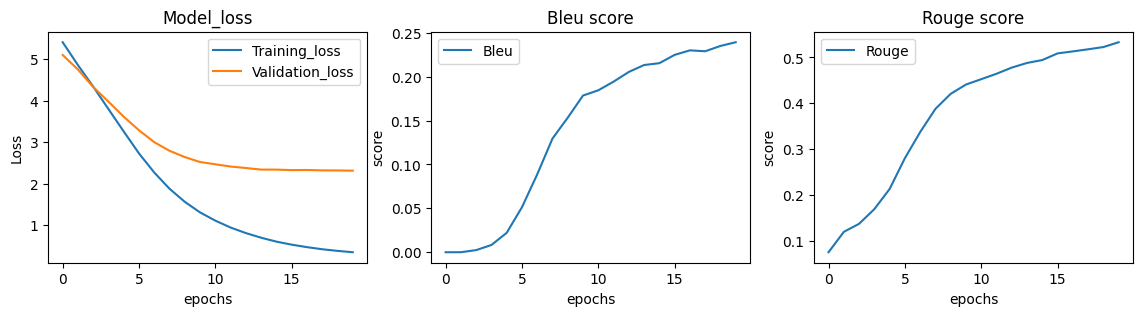

In [157]:
#visualize the model performance
fig, (ax1, ax3,ax4) = plt.subplots(1, 3, figsize=(14,3))
# plot some data
ax1.plot(train_losses, label='Training_loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Model_loss')

ax1.legend()
ax1.plot(val_losses, label='Validation_loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epochs')
ax1.legend()

ax3.plot(val, label='Bleu')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax3.set_title('Bleu score')

ax3.set_ylabel('score')
ax3.set_xlabel('epochs')
ax3.legend()
# accuracies
ax4.plot(val_metric, label='Rouge')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax4.set_ylabel('score')
ax4.set_xlabel('epochs')
ax4.set_title('Rouge score')
ax4.legend()
plt.show()


In [158]:
def predict(sentence):
  attention_plot = np.zeros((MAX_SUMM_LENGTH, MAX_TEXT_LENGTH))

  sentence = '<start> '+sentence+' <end>'

  inputs = [tokenizer_inputs.word_index[i] if tokenizer_inputs.word_index[i] < input_vocab_size
            else tokenizer_inputs.word_index['<unk>'] for i in sentence.split(' ')]
  inputs = pad_sequences([inputs], maxlen=MAX_TEXT_LENGTH,padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, UNITS))]
  enc_out, states = encoder(inputs) #, hidden)

  #dec_hidden = enc_hidden
  dec_hidden = [tf.add(states["for_h"], states["bac_h"]), tf.add(states["for_c"], states["bac_c"])]
  dec_input = tf.expand_dims([tokenizer_outputs.word_index['<start>']], 0)

  for t in range(MAX_SUMM_LENGTH):
    predictions, dec_hidden, attention_weights = decoder((dec_input,
                                                          enc_out,
                                                          dec_hidden))

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tokenizer_outputs.index_word[predicted_id] + ' '

    if tokenizer_outputs.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [159]:
#visualization of results
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add axis labels
    ax.set_xlabel('Sarcastic Sentence', fontsize=16, labelpad=20)
    ax.set_ylabel('Non-Sarcastic Sentence', fontsize=16, labelpad=20)

    plt.colorbar(cax)
    plt.title('Attention Map', fontsize=18)
    plt.show()

In [57]:
from tensorflow.keras.utils import pad_sequences

In [160]:
def interpret_sarcasm(sentence):
  result, sentence, attention_plot = predict(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> best day of my life <end>
Predicted translation: worst day of my life <end> 


<ipython-input-159-8d2a3faf60fb>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-159-8d2a3faf60fb>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


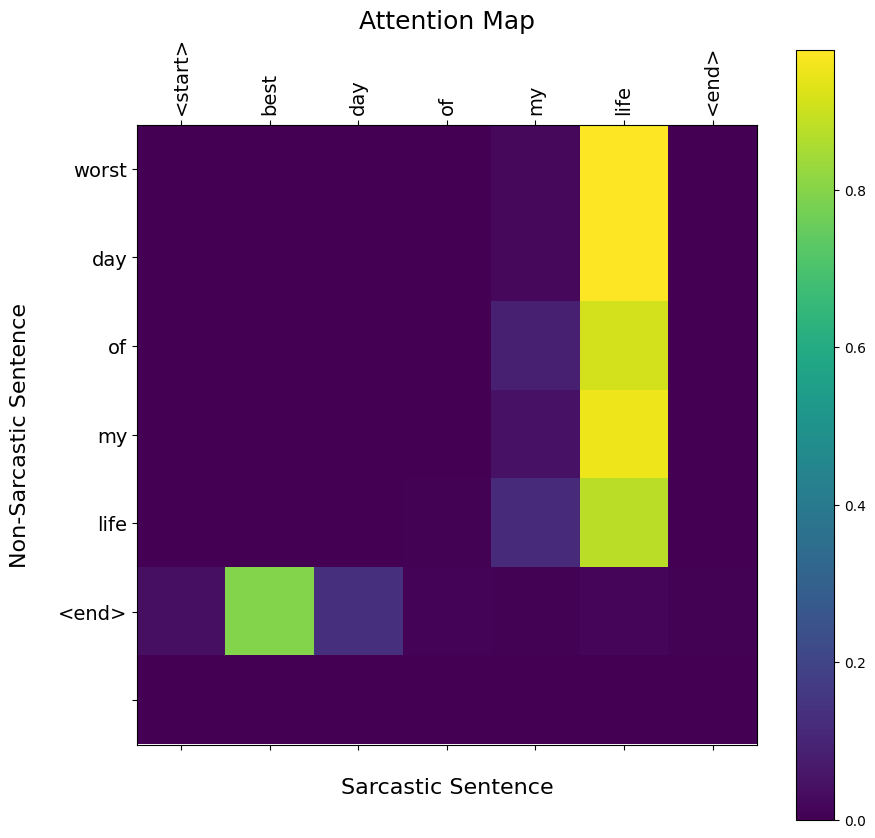

In [161]:
interpret_sarcasm('best day of my life')

Input: <start> after 9 hours of waiting wow im sooo important <end>
Predicted translation: after 9 hours of waiting wow im sooo important <end> 


<ipython-input-159-8d2a3faf60fb>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-159-8d2a3faf60fb>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


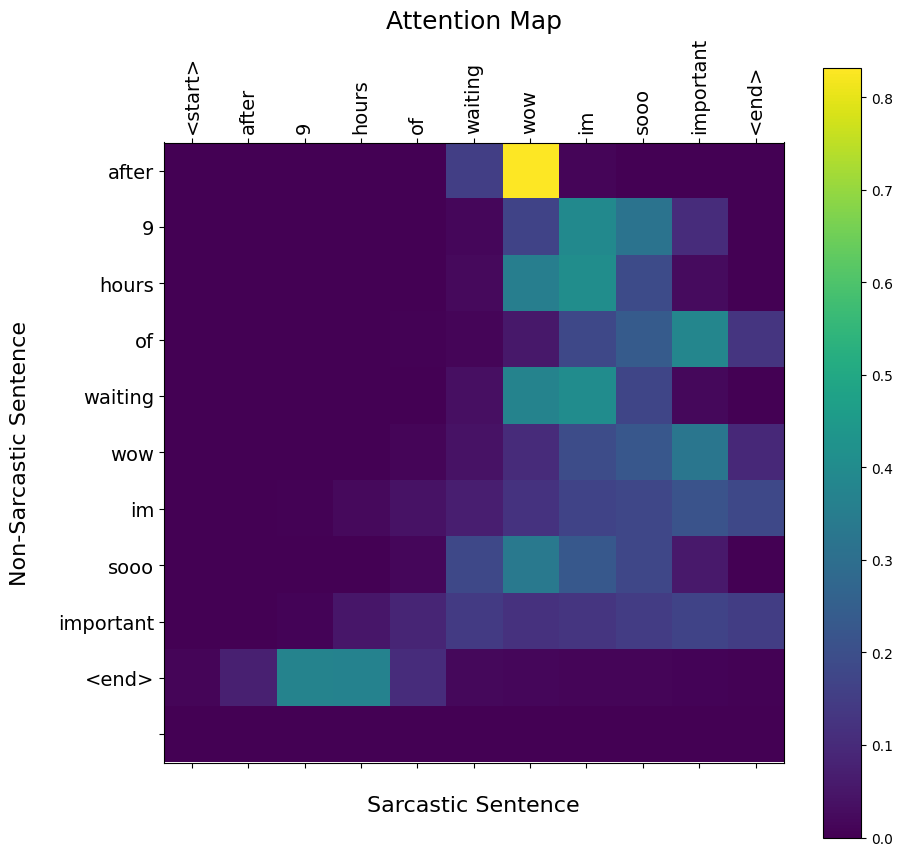

In [162]:
interpret_sarcasm('after 9 hours of waiting wow im sooo important')

Input: <start> this 12 hour overnight shift is going to be lit <end>
Predicted translation: this 12 hour overnight shift is going to be lit <end> 


<ipython-input-159-8d2a3faf60fb>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-159-8d2a3faf60fb>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


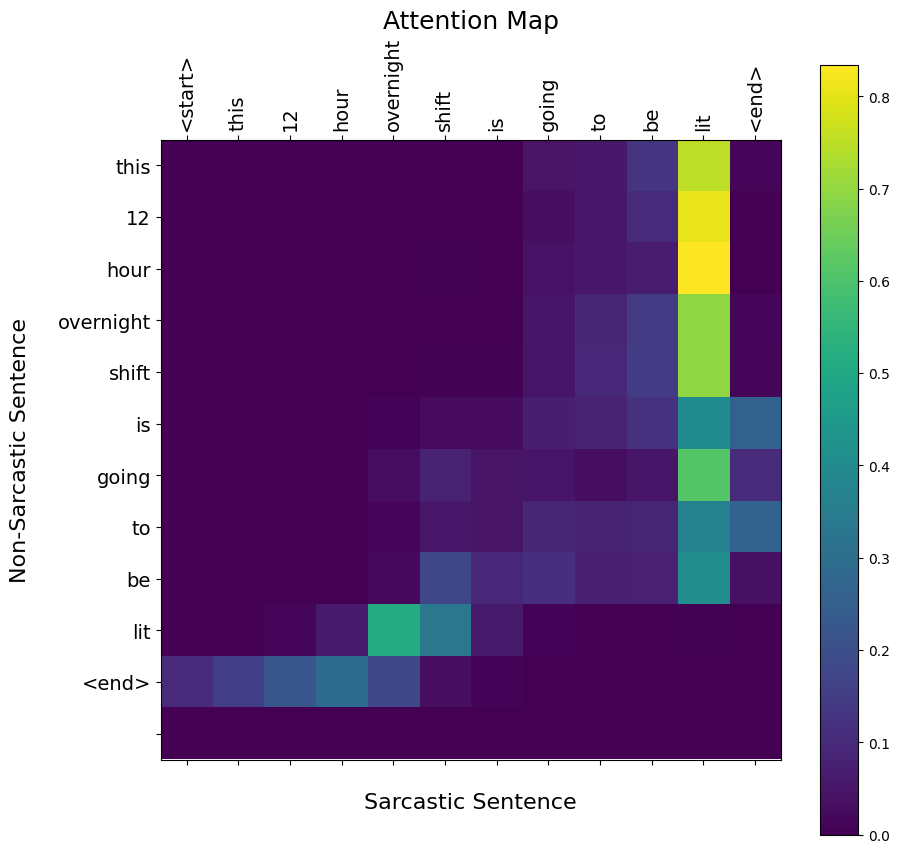

In [174]:
interpret_sarcasm('this 12 hour overnight shift is going to be lit')

Input: <start> love working when the weather is like this outside <end>
Predicted translation:  hate working when the weather is like this outside <end> 


<ipython-input-159-8d2a3faf60fb>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-159-8d2a3faf60fb>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


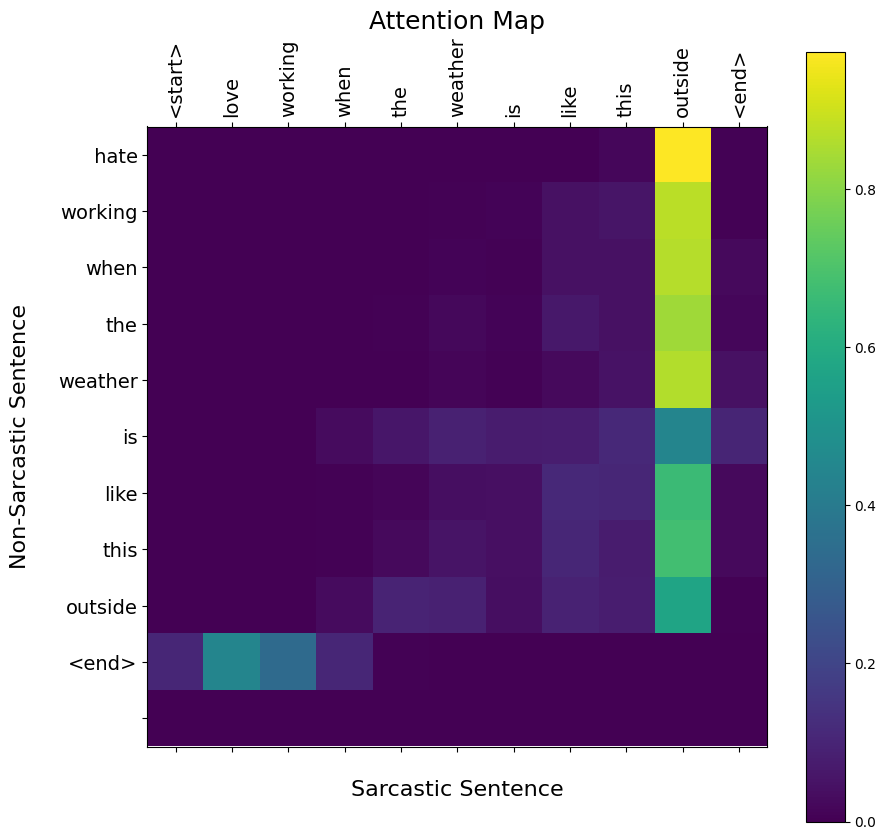

In [176]:
interpret_sarcasm('love working when the weather is like this outside')

Input: <start> such fucking friends you guys are <end>
Predicted translation:  you guys are such a great friends <end> 


<ipython-input-159-8d2a3faf60fb>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-159-8d2a3faf60fb>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


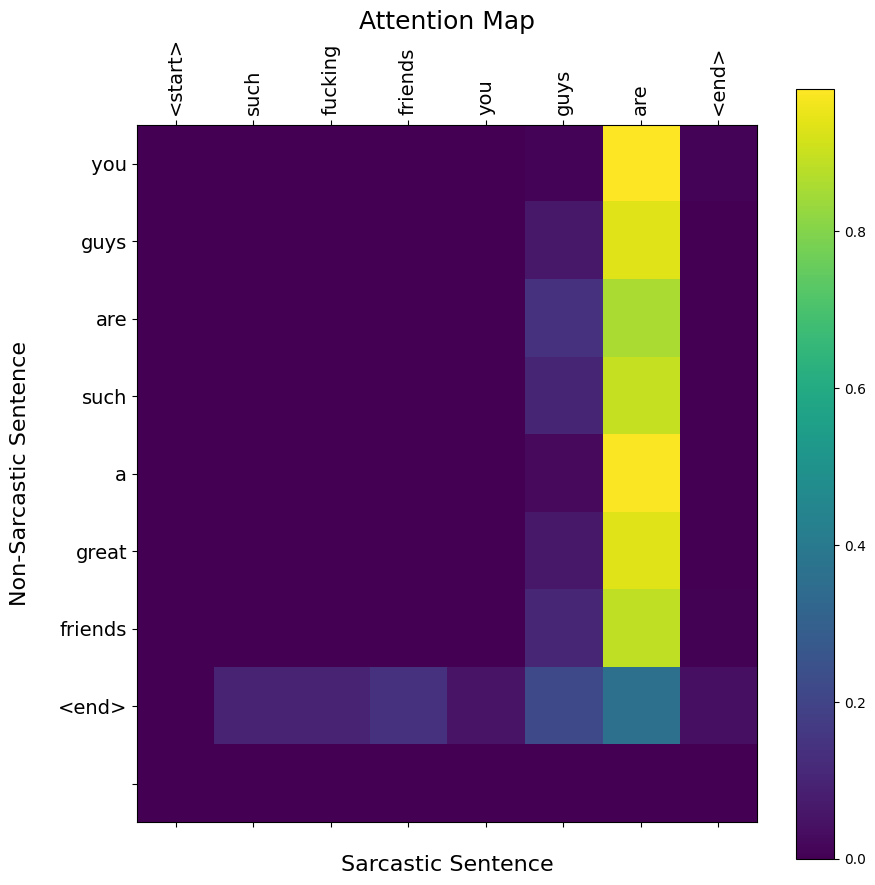

In [166]:
interpret_sarcasm('such fucking friends you guys are')

Input: <start> i feel loved 0 message <end>
Predicted translation:  i don't feel loved no messages <end> 


<ipython-input-159-8d2a3faf60fb>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-159-8d2a3faf60fb>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


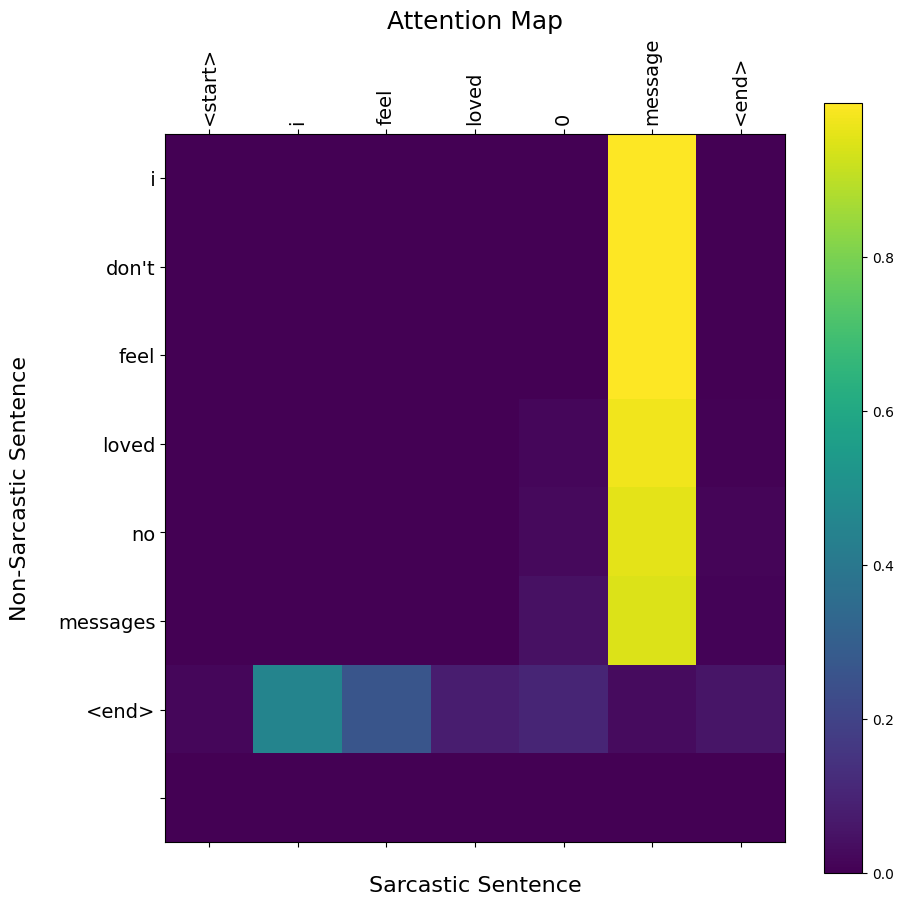

In [167]:
interpret_sarcasm('i feel loved 0 message')